In [22]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
import random

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_openml

# import custom module
from mnist_helpers import *

# it creates mldata folder in your root project folder
mnist = fetch_openml('mnist_784')

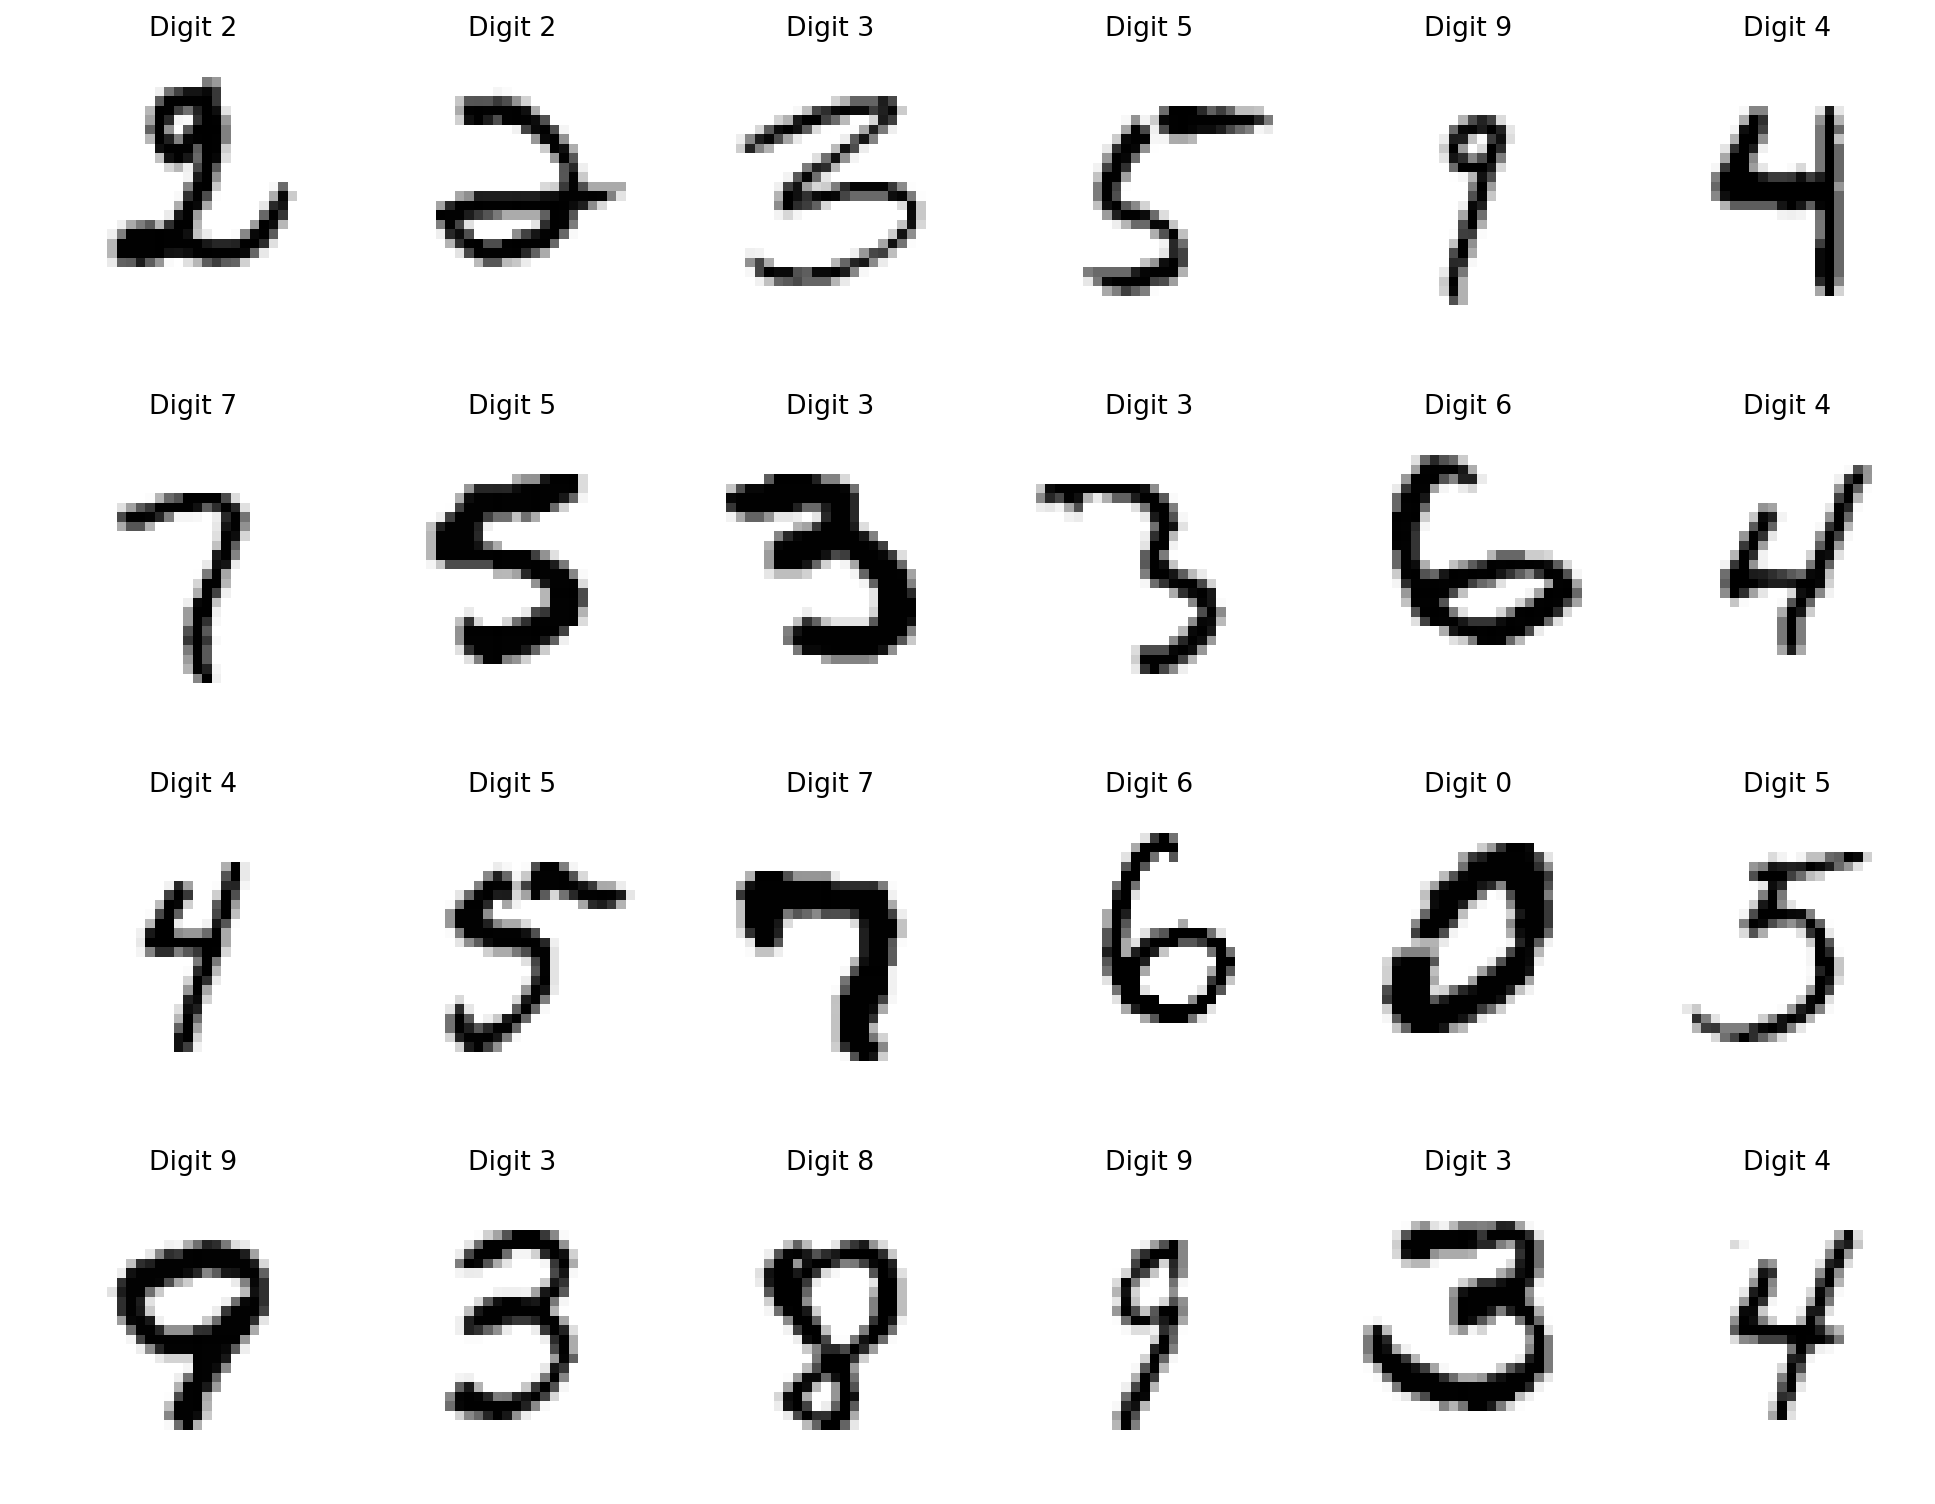

In [23]:
#minist object contains: data, COL_NAMES, DESCR, target fields
#you can check it by running
mnist.keys()

#data field is 70k x 784 array, each row represents pixels from 28x28=784 image
images = mnist.data
targets = mnist.target

# Let's have a look at the random 16 images, 
# We have to reshape each data row, from flat array of 784 int to 28x28 2D array

#pick  random indexes from 0 to size of our dataset
show_some_digits(images,targets)

In [24]:
#---------------- classification begins -----------------
#scale data for [0,255] -> [0,1]
#sample smaller size for testing
#rand_idx = np.random.choice(images.shape[0],10000)
#X_data =images[rand_idx]/255.0
#Y      = targets[rand_idx]

#full dataset classification
X_data = images/255.0
Y = targets

In [25]:
# change the porblem to binary classification problem
y = []
for i in Y:
    if i == '0':
        y.append(1)
    else:
        y.append(-1)
y = np.array(y)

print(X_data.shape)
print(y.shape)

(70000, 784)
(70000,)


In [26]:
#solver info

# Condition metric
def H(X, y, theta):
    y = y.reshape(y.shape[0], 1) # change to 2d array
    return (1 - y * (X@theta))

def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*(theta.T @ theta)
    loss = np.mean([max(0, i) for i in h])
    return np.asscalar(penalty) + np.asscalar(loss) 

def svm_grad_re(X, y, theta, lamda):
    h = H(X, y, theta)
    y = y.reshape(y.shape[0], 1) # change to 2d array
    cond = np.array([(i > 0)*1 for i in h])
    return 2*lamda*theta - X.T @ (y*cond)/y.shape[0]


In [31]:
#compress information: Q1 and Q2 method
def quantize_Q1(input_weight):
    """
    Q1: quantize vector
    """
    weight = input_weight
    #define K values
    K = 100
    chosen_row_index = np.random.randint(weight.shape[0], size=(weight.shape[0] - K))
    
    for column in range(weight.shape[1]):
        weight[chosen_row_index, column] = 0
        
    return weight
    

def quantize_Q2(input_weight):
    """
    Q2: represent every element with less bits
    """
    
    weight = input_weight
    bins = np.linspace(-1, 1, 2**16)
    inds = np.digitize(np.clip(weight, -1, 1), bins, right=True) #incresing
    weight_bar = bins[inds] 
    
    return weight_bar



In [76]:
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 1)
    total_loss_list=[]
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    for i_iter in range(num_iter):
        gradient_list=[]
        for j_worker in range(num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            # add noise
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro <= pLevel)
            gradient_list.append(grad)
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        total_loss_list.append(svm_loss_re(X_data, y, weight, lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter)
    
    return total_loss_list, total_signal_exchange_list   

In [77]:
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_Q1(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 1)
    total_loss_list=[]
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    for i_iter in range(num_iter):
        gradient_list=[]
        for j_worker in range(num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            # add noise
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro <= pLevel)
            #add compression- Q1 method
            grad_Q1 = quantize_Q1(grad)
            
            gradient_list.append(grad_Q1)
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        total_loss_list.append(svm_loss_re(X_data, y, weight, lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter*100/784.)
    
    return total_loss_list, total_signal_exchange_list   

In [78]:
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_Q2(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 1)
    total_loss_list=[]
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    for i_iter in range(num_iter):
        gradient_list=[]
        for j_worker in range(num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            # add noise
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro <= pLevel)
            #add compression- Q1 method
            grad_Q2 = quantize_Q2(grad)
            
            gradient_list.append(grad_Q2)
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        total_loss_list.append(svm_loss_re(X_data, y, weight, lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter/2.)
    
    return total_loss_list, total_signal_exchange_list   

In [79]:
# default number of iteration = 200
def tuningNoise(var, pLevel):
    return train(X_data, y, num_worker=10, num_iter=200, var=var, pLevel=pLevel, lamda=0.03, alpha=0.02, lr_fade=1)

## Characterize the convergence against the # signalling exchanges

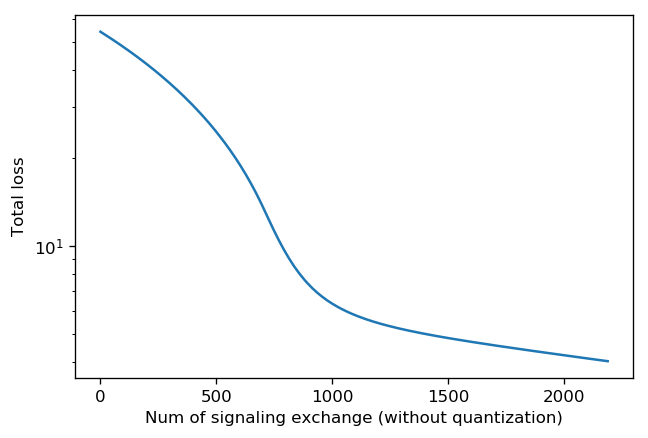

In [42]:
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss, list_total_signal_exchge = train(X_data, y, num_worker=10, num_iter=200, var = 0, pLevel=0, 
                                                  lamda=0.03, alpha=0.02, lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis = list_total_signal_exchge
y_axis = list_total_loss
plt.semilogy(x_axis, y_axis)
plt.xlabel('Num of signaling exchange (without quantization)')
plt.ylabel('Total loss')
plt.show()

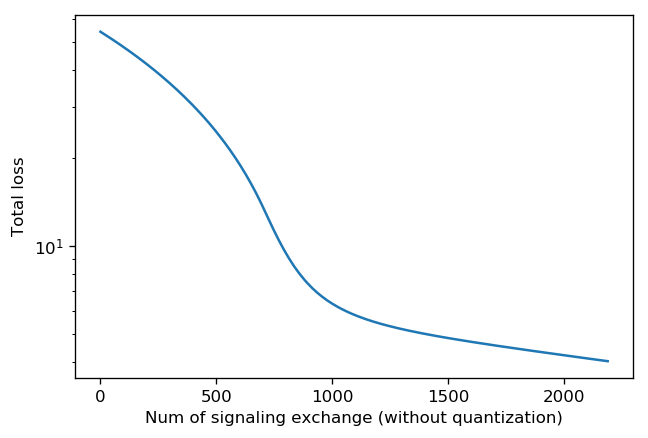

In [59]:
#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis = list_total_signal_exchge
y_axis = list_total_loss
plt.semilogy(x_axis, y_axis)
plt.xlabel('Num of signaling exchange (without quantization)')
plt.ylabel('Total loss')
plt.savefig('CA5_b_dgd.png')
plt.show()

In [62]:
list_total_signal_exchge[-10:]

[2090, 2101, 2112, 2123, 2134, 2145, 2156, 2167, 2178, 2189]

In [43]:
#plt.semilogy(x_axis, y_axis)
#plt.xlabel('Num of signaling exchange')
#plt.ylabel('Total loss')
#plt.savefig('CA5-a_.png')
#plt.show()

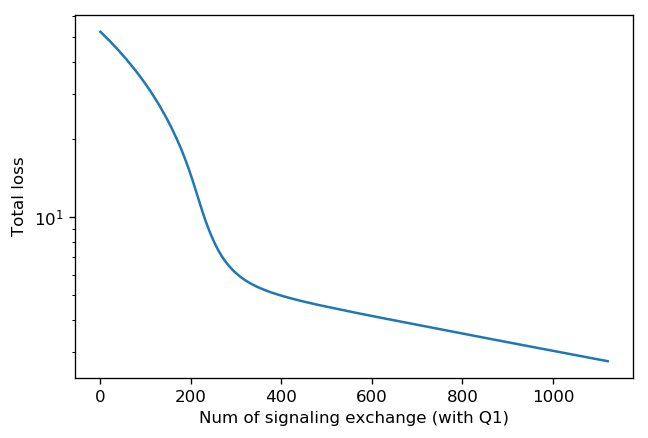

In [80]:
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss_Q1, list_total_signal_exchge_Q1 = train_Q1(X_data, y, num_worker=10, num_iter=800, var = 0, pLevel=0, 
                                                  lamda=0.03, alpha=0.02, lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis = list_total_signal_exchge_Q1
y_axis = list_total_loss_Q1
plt.semilogy(x_axis, y_axis)
plt.xlabel('Num of signaling exchange (with Q1)')
plt.ylabel('Total loss')
plt.show()

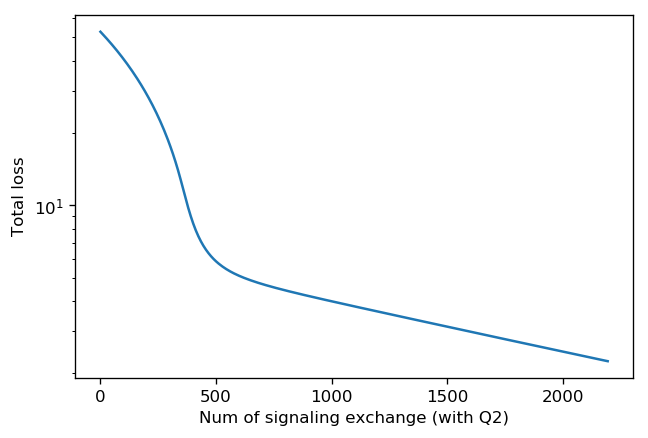

In [81]:
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss_Q2, list_total_signal_exchge_Q2 = train_Q2(X_data, y, num_worker=10, num_iter=400, var = 0, pLevel=0, 
                                                  lamda=0.03, alpha=0.02, lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis = list_total_signal_exchge_Q2
y_axis = list_total_loss_Q2
plt.semilogy(x_axis, y_axis)
plt.xlabel('Num of signaling exchange (with Q2)')
plt.ylabel('Total loss')
plt.show()

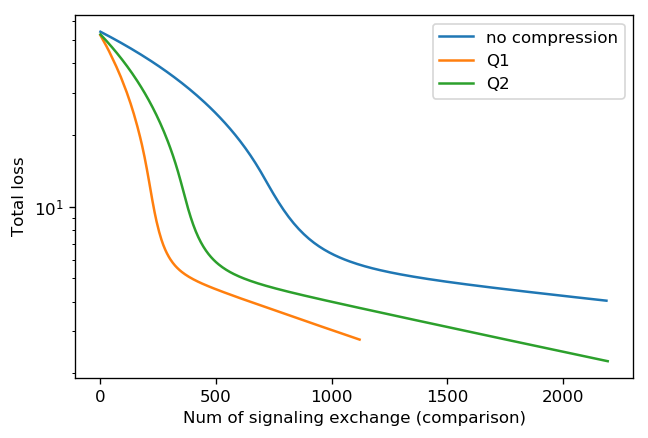

In [89]:
#comparison among case without quantization and with quantizaiton
#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

plt.semilogy(list_total_signal_exchge, list_total_loss, list_total_signal_exchge_Q1, list_total_loss_Q1,
             list_total_signal_exchge_Q2, list_total_loss_Q2)
plt.xlabel('Num of signaling exchange (comparison)')
plt.legend(['no compression', 'Q1', 'Q2'], loc='upper right')
plt.ylabel('Total loss')
#plt.savefig('comparison_cdg_v2.png')
plt.show()

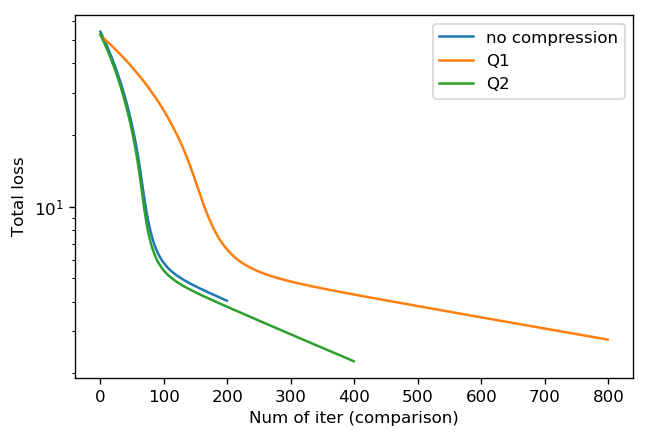

In [101]:
#comparison among case without quantization and with quantizaiton
#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

num_iter_1 = [signal_exchange/11. for signal_exchange in list_total_signal_exchge]
num_iter_2 = [signal_exchange/100.*784/11. for signal_exchange in list_total_signal_exchge_Q1]
num_iter_3 = [signal_exchange*2./11. for signal_exchange in list_total_signal_exchge_Q2]

plt.semilogy(num_iter_1, list_total_loss, num_iter_2, list_total_loss_Q1,
             num_iter_3, list_total_loss_Q2)
plt.xlabel('Num of iter (comparison)')
plt.legend(['no compression', 'Q1', 'Q2'], loc='upper right')
plt.ylabel('Total loss')
plt.savefig('comparison_cdg_iter.png')
plt.show()

(b) two-star topo

In [48]:
#two-star topo
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_2_star_topo(X_data, y, num_worker_left, num_worker_right, num_iter, var, pLevel, lamda, alpha, lr_fade):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    
    w_init = np.random.rand(X_data.shape[1], 1)
    weight, weight_left, weight_right = w_init, w_init, w_init
    
    total_loss_list = []
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    
    num_data = len(y)
    num_worker = num_worker_left + num_worker_right
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
       
    for i_iter in range(num_iter):
        #left topo
        gradient_list_left, gradient_list_right = [], []
        for j_worker in range(num_worker_left):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from left topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_left.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_left -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #right topo
        for j_worker in range(num_worker_right, num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from right topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            gradient_list_right.append(grad)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_right -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #upodate weight based on weight_left and weight_right
        weight = 1/2*(weight_left + weight_right)
        
        total_loss_list.append(svm_loss_re(X_data, y, weight,lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter)
        
    return total_loss_list, total_signal_exchange_list

    

In [49]:
#two-star topo
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_2_star_topo_Q1(X_data, y, num_worker_left, num_worker_right, num_iter, var, pLevel, lamda, alpha, lr_fade):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    
    w_init = np.random.rand(X_data.shape[1], 1)
    weight, weight_left, weight_right = w_init, w_init, w_init
    
    total_loss_list = []
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    
    num_data = len(y)
    num_worker = num_worker_left + num_worker_right
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
       
    for i_iter in range(num_iter):
        #left topo
        gradient_list_left, gradient_list_right = [], []
        for j_worker in range(num_worker_left):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from left topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            #add compression for grad-Q1
            grad_Q1 = quantize_Q1(grad)
            gradient_list_left.append(grad_Q1)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_left -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #right topo
        for j_worker in range(num_worker_right, num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from right topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            #add compression for grad- Q1
            grad_Q1 = quantize_Q1(grad)
            gradient_list_right.append(grad_Q1)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_right -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #upodate weight based on weight_left and weight_right
        weight = 1/2*(weight_left + weight_right)
        
        total_loss_list.append(svm_loss_re(X_data, y, weight,lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter)
        
    return total_loss_list, total_signal_exchange_list

    

In [51]:
#two-star topo
# lamda: penalty
# alpha: learning rate
# var: noise variance
# pLevel: noise adding probability
# num_iter: number of iterations
def train_2_star_topo_Q2(X_data, y, num_worker_left, num_worker_right, num_iter, var, pLevel, lamda, alpha, lr_fade):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    
    w_init = np.random.rand(X_data.shape[1], 1)
    weight, weight_left, weight_right = w_init, w_init, w_init
    
    total_loss_list = []
    total_signal_exchange_list = []
    num_signal_exchange_per_iter = 10+1
    
    num_data = len(y)
    num_worker = num_worker_left + num_worker_right
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
       
    for i_iter in range(num_iter):
        #left topo
        gradient_list_left, gradient_list_right = [], []
        for j_worker in range(num_worker_left):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from left topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            #add compression for grad-Q2
            grad_Q2 = quantize_Q2(grad)
            gradient_list_left.append(grad_Q2)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_left -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #right topo
        for j_worker in range(num_worker_right, num_worker):
            #call data_j from worker j
            X_worker = data_X_list[j_worker]
            y_worker =data_y_list[j_worker]
            # get grad from right topo worker j
            grad = svm_grad_re(X_worker, y_worker, weight, lamda)
            noise = np.random.normal(0, var)
            pro = random.uniform(0,1)
            grad = grad + noise * (pro>=pLevel)
            #add compression for grad- Q1
            grad_Q2 = quantize_Q2(grad)
            gradient_list_right.append(grad_Q2)
        #updata weight with average grad for left branch workers
        alpha *= lr_fade
        weight_right -= alpha * 1./num_worker*sum(gradient_list_left)
        
        #upodate weight based on weight_left and weight_right
        weight = 1/2*(weight_left + weight_right)
        
        total_loss_list.append(svm_loss_re(X_data, y, weight,lamda))
        total_signal_exchange_list.append(i_iter*num_signal_exchange_per_iter)
        
    return total_loss_list, total_signal_exchange_list

    

## Characterize the convergence against the # signalling exchanges

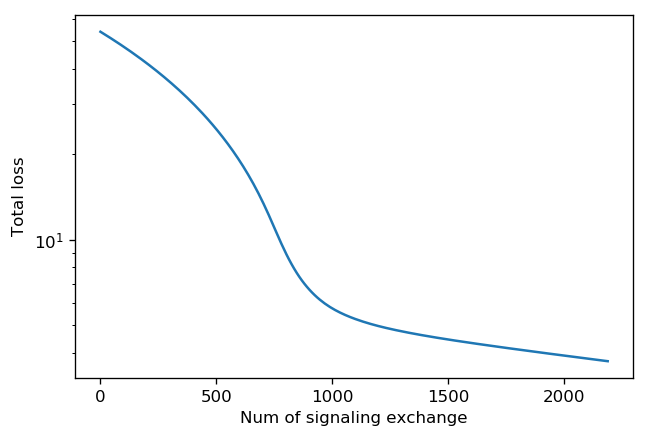

In [52]:
#Decentralized GD
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss2, list_total_signal_exchge2 = train_2_star_topo(X_data, y, num_worker_left=5, num_worker_right=5,
                                                             num_iter=200, var=0, pLevel=0, lamda=0.03, alpha=0.02,
                                                             lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis2 = list_total_signal_exchge2
y_axis2 = list_total_loss2
plt.semilogy(x_axis2, y_axis2)
plt.xlabel('Num of signaling exchange')
plt.ylabel('Total loss')
#plt.savefig('CA5-b_decentralizedGD.png')
plt.show()

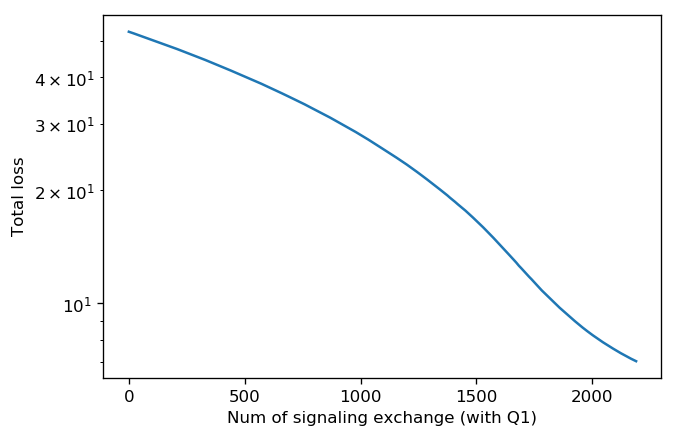

In [53]:
#Decentralized GD
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss2_Q1, list_total_signal_exchge2_Q1 = train_2_star_topo_Q1(X_data, y, num_worker_left=5, num_worker_right=5,
                                                             num_iter=200, var=0, pLevel=0, lamda=0.03, alpha=0.02,
                                                             lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis2 = list_total_signal_exchge2_Q1
y_axis2 = list_total_loss2_Q1
plt.semilogy(x_axis2, y_axis2)
plt.xlabel('Num of signaling exchange (with Q1)')
plt.ylabel('Total loss')
#plt.savefig('CA5-b_decentralizedGD.png')
plt.show()

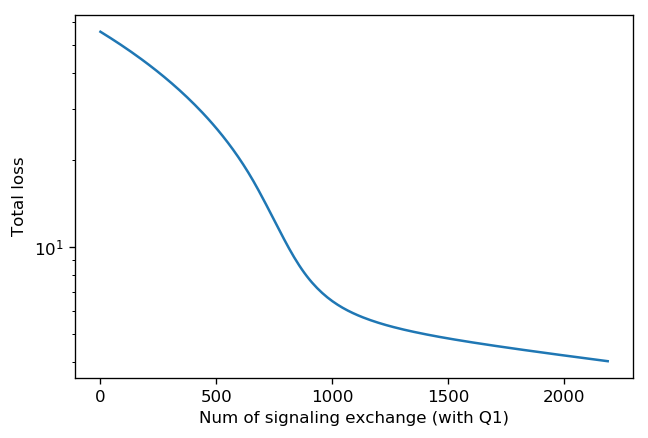

In [54]:
#Decentralized GD
#train 10 workers with decentralized GD
#here we set noise = 0 meaning that there is no noise
list_total_loss2_Q2, list_total_signal_exchge2_Q2 = train_2_star_topo_Q2(X_data, y, num_worker_left=5, num_worker_right=5,
                                                             num_iter=200, var=0, pLevel=0, lamda=0.03, alpha=0.02,
                                                             lr_fade=1)

#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

x_axis2 = list_total_signal_exchge2_Q2
y_axis2 = list_total_loss2_Q2
plt.semilogy(x_axis2, y_axis2)
plt.xlabel('Num of signaling exchange (with Q1)')
plt.ylabel('Total loss')
#plt.savefig('CA5-b_decentralizedGD.png')
plt.show()

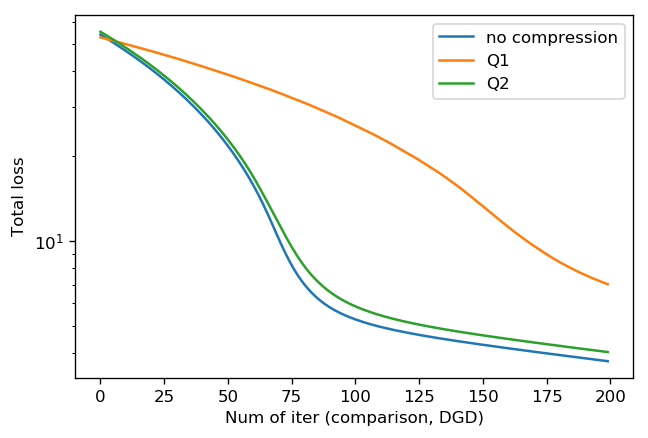

In [96]:
#comparison among case without quantization and with quantizaiton
#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

num_iter_cdg1 = [signal_exchange/11. for signal_exchange in list_total_signal_exchge2]
num_iter_cdg2 = [signal_exchange/11. for signal_exchange in list_total_signal_exchge2_Q1]
num_iter_cdg3 = [signal_exchange/11. for signal_exchange in list_total_signal_exchge2_Q2]

plt.semilogy(num_iter_cdg1, list_total_loss2, num_iter_cdg2, list_total_loss2_Q1,
             num_iter_cdg3, list_total_loss2_Q2)
plt.xlabel('Num of iter (comparison, DGD)')
plt.legend(['no compression', 'Q1', 'Q2'], loc='upper right')
plt.ylabel('Total loss')
#plt.savefig('comparison_dgd_iter.png')
plt.show()

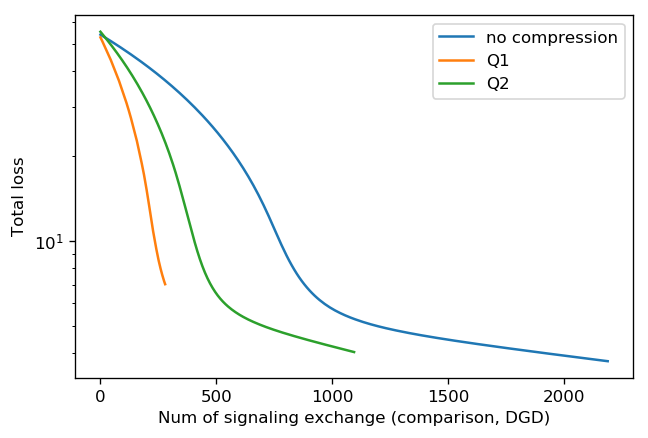

In [99]:
#comparison among case without quantization and with quantizaiton
#visualize the loss vs signal exchange
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

num_iter_cdg11 = [signal_exchange for signal_exchange in list_total_signal_exchge2]
num_iter_cdg22 = [signal_exchange/784.*100 for signal_exchange in list_total_signal_exchge2_Q1]
num_iter_cdg33 = [signal_exchange/2. for signal_exchange in list_total_signal_exchge2_Q2]

plt.semilogy(num_iter_cdg11, list_total_loss2, num_iter_cdg22, list_total_loss2_Q1,
             num_iter_cdg33, list_total_loss2_Q2)
plt.xlabel('Num of signaling exchange (comparison, DGD)')
plt.legend(['no compression', 'Q1', 'Q2'], loc='upper right')
plt.ylabel('Total loss')
plt.savefig('comparison_dgd_commu.png')
plt.show()

## Characterize the convergence against the # signalling exchanges

In [12]:
#ADMM part
#train 10 workers with ADMM algorithm in two-star topo
#here we set noise = 0 meaning that there is no noise